In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from matplotlib import pyplot as plt
import numpy as np

In [3]:
tweets_df = pd.read_csv('Data/training.csv',encoding='latin1', header=None)

In [4]:
tweets_df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
y = tweets_df[0]
X = tweets_df[5]

In [6]:
y.describe()

count    1.600000e+06
mean     2.000000e+00
std      2.000001e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      4.000000e+00
Name: 0, dtype: float64

## Exploratory Data Analysis

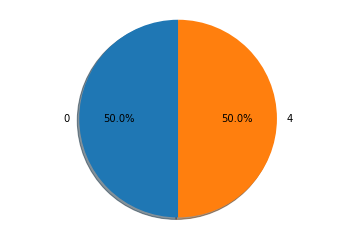

In [7]:
# check the distribution of labels in the data
label_counts = pd.value_counts(y.values, sort=False)
fig1, ax1 = plt.subplots()
ax1.pie(label_counts.values, labels=list(label_counts.keys()),shadow=True, startangle=90, autopct='%1.1f%%')
ax1.axis('equal')
plt.show()

## Preprocessing

In [8]:
import re
for i in range(len(X.values)):
    X.values[i] = X.values[i].lower()
    X.values[i] = re.sub('@\w+', 'USERNAME', X.values[i])
    X.values[i] = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', X.values[i])
    X.values[i] = re.sub('-|,|\.|\?|!|#|&quot;|[|]|:|;', '', X.values[i])

## Base Model: Naive Bayes

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1,shuffle=True)

In [10]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.values)

In [11]:
X_test_counts = count_vect.transform(X_test.values)

In [12]:
clf = MultinomialNB()
clf.fit(X_train_counts, y_train)
predicted = clf.predict(X_test_counts)
print(clf.score(X_test_counts, y_test))

0.7798030303030303


## Base Model: SVM

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)

clf.fit(X_train_counts, y_train)  
predicted = clf.predict(X_test_counts)
np.mean(predicted == y_test)      

0.7699602272727273

## Word2vec

In [16]:
import gensim

In [17]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('words2vecmodel/GoogleNews-vectors-negative300.bin', binary=True)

In [19]:
embedding_size = model.vector_size

In [20]:
def get_max_length(data):
    max_review_length = 0
    for r in data:
        words = r.split()
        if len(words) > max_review_length:
            max_review_length = len(words)
    return max_review_length

In [21]:
max_length_train = get_max_length(X_train.values)

In [22]:
max_length_test = get_max_length(X_test.values)

In [23]:
def sentence_to_vect(review, max_review_length):
    sent_vector = np.zeros((max_review_length, embedding_size))
    for i, word in enumerate(review.split()):
        if word in model.vocab:
            sent_vector[i, :] = model[word]
    return sent_vector

## CNN

In [24]:
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
def cnn_model_fn(features, labels, mode):
    # Input Layer
    #input_layer = tf.reshape(tf.to_float(features), [-1, params['max_review_length'], embedding_size])
    #input_layer = tf.to_float(features)
    input_layer = features
    # Convolutional Layer #1
    pool_outs = []
    for filter_shape in [3,4,5]:
        conv = tf.layers.conv1d(inputs=input_layer,filters=100, kernel_size=filter_shape, strides=1, padding="valid", activation=tf.nn.relu)
        pool_outs.append(tf.reduce_max(conv, axis=1))
    conv_pool_output = tf.concat(pool_outs,axis=1)
    # Dense Layer
    #conv_pool_output_flat = tf.reshape(conv_pool_output, [-1, conv_pool_output.shape[0] * conv_pool_output.shape[1]])
    #print(conv_pool_output_flat)
    dense = tf.layers.dense(inputs=conv_pool_output, units=3, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1, name="class_predicted"),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)


    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"], name="model_accuracy")}
    
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [26]:
# Create the Estimator
sentiment_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, 
                                              model_dir="checkpoint/model")
# Set up logging for predictions
tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'checkpoint/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1b8cda3438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [27]:
def review2vec(x, y):
    for i, review in enumerate(x):
        features = np.array(sentence_to_vect(review, 140))
        label = y.values[i]
        yield features, label

def get_dataset(x, y):
    generator = lambda: review2vec(x, y)
    return tf.data.Dataset.from_generator(
        generator, (tf.float32, tf.int32),((140,300), ()))

In [28]:
# create input function
def get_inputs(batch_size, x, y):
    dataset = get_dataset(x, y)
    dataset = dataset.repeat()  # repeat indefinitely
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    features, label = dataset.make_one_shot_iterator().get_next()
    return features, label

In [29]:
# Train the model
#train_input_fn = tf.estimator.inputs.numpy_input_fn(x=training_data,y=y_train.values-1, batch_size=1000, shuffle=True, num_epochs=None)
sentiment_classifier.train(input_fn=lambda:get_inputs(1000, X_train, y_train - (y_train * 3/4)),steps=3000,hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from checkpoint/model/model.ckpt-56421
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 56421 into checkpoint/model/model.ckpt.
INFO:tensorflow:
INFO:tensorflow:loss = 0.43216926, step = 56422
INFO:tensorflow:Saving checkpoints for 56422 into checkpoint/model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.43216926.


In [30]:
# Evaluate the model and print results
eval_results = sentiment_classifier.evaluate(input_fn=lambda:get_inputs(1, X_test, y_test - (y_test * 3/4)),steps=X_test.shape[0])
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-05-23:41:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from checkpoint/model/model.ckpt-56422
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [52800/528000]
INFO:tensorflow:Evaluation [105600/528000]
INFO:tensorflow:Evaluation [158400/528000]
INFO:tensorflow:Evaluation [211200/528000]
INFO:tensorflow:Evaluation [264000/528000]
INFO:tensorflow:Evaluation [316800/528000]
INFO:tensorflow:Evaluation [369600/528000]
INFO:tensorflow:Evaluation [422400/528000]
INFO:tensorflow:Evaluation [475200/528000]
INFO:tensorflow:Evaluation [528000/528000]
INFO:tensorflow:Finished evaluation at 2019-02-06-00:39:49
INFO:tensorflow:Saving dict for global step 56422: accuracy = 0.81216097, global_step = 56422, loss = 0.41196048
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 56422: